In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import percentile

import plotly
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

### Data Preprocessing

In [2]:
sales_df = pd.read_csv('promo_order_data.csv', parse_dates = ['trans_date'])

In [3]:
## Check null values

sales_df.isnull().sum()

## promo_amount column does not contain any values.
## Assume null values under device used columns to be 0.

sales_df = sales_df.drop(columns = 'promo_amount')
sales_df = sales_df.fillna(0)

In [4]:
sales_df['month'] = sales_df['trans_date'].dt.month
sales_df['week'] = sales_df['trans_date'].dt.isocalendar().week
## 0-Monday, 6-Sunday
sales_df['dayofweek'] = sales_df['trans_date'].dt.weekday

## Create 'other_devices' column for customers not using any of the indicated devices.
sales_df['other_devices'] = sales_df['customers'] - sales_df[['Android', 'GCF', 'Macintosh', 'Tablet',
       'Windows', 'X11', 'iPhone']].sum(axis=1)
sales_df['phone'] = sales_df[['Android','Tablet','iPhone']].sum(axis=1)
sales_df['laptop'] = sales_df[['Macintosh','Windows', 'X11']].sum(axis=1)

sales_df['orders/customers'] = sales_df['orders']/sales_df['customers']
sales_df['orders/vendors'] = sales_df['orders']/sales_df['vendors']
sales_df['amount/customers'] = sales_df['amount']/sales_df['customers']
sales_df['amount/vendors'] = sales_df['amount']/sales_df['vendors']
sales_df['amount/orders'] = sales_df['amount']/sales_df['orders']
sales_df['promo/orders'] = sales_df['promo_count']/sales_df['orders']

## Remove week 53 and week 22 data.
# sales_df = sales_df[sales_df['week']!=53]

In [5]:
sales_df[['customers', 'vendors', 'orders', 'amount',
       'promo_count', 'Android', 'GCF', 'Macintosh', 'Tablet', 'Windows',
       'X11', 'iPhone', 'Blacklisted', 'Not Blacklisted','orders/customers',
       'orders/vendors', 'amount/customers', 'amount/vendors', 'amount/orders',
       'promo/orders']].describe()

,customers,vendors,orders,amount,promo_count,Android,GCF,Macintosh,Tablet,Windows,X11,iPhone,Blacklisted,Not Blacklisted,orders/customers,orders/vendors,amount/customers,amount/vendors,amount/orders,promo/orders
count,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000,2485.000000
mean,1368.490946,388.434608,1391.750503,10501.810254,28.863581,76.028169,24.264789,1.474447,0.792757,3.099396,3.967002,409.124346,0.123139,1368.367807,1.015788,2.426814,15.958533,29.603154,15.762066,0.021326
std,2004.241830,408.808706,2035.524228,13429.995228,52.014765,107.789983,27.442971,2.546004,1.620405,4.702607,5.272650,574.585989,0.516366,2004.155656,0.029177,1.342453,15.743990,21.406405,15.667700,0.061737
min,2.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,28.000000,20.000000,28.000000,625.800000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,28.000000,1.000000,1.406250,6.940422,16.440000,6.835333,0.000000
50%,474.000000,254.000000,482.000000,4485.200000,4.000000,26.000000,12.000000,0.000000,0.000000,0.000000,2.000000,136.000000,0.000000,474.000000,1.013652,1.981308,9.078613,24.093526,8.905117,0.008547
75%,1892.000000,624.000000,1924.000000,14793.460000,32.000000,106.000000,40.000000,2.000000,2.000000,4.000000,6.000000,640.000000,0.000000,1892.000000,1.020408,3.151515,14.613333,36.566393,14.477778,0.024793
max,9910.000000,1482.000000,10046.000000,63756.420000,442.000000,556.000000,138.000000,16.000000,12.000000,30.000000,30.000000,2918.000000,4.000000,9910.000000,1.500000,7.008475,129.100000,284.500000,129.100000,1.000000


Text(0.5, 1.0, 'Correlation Heatmap')

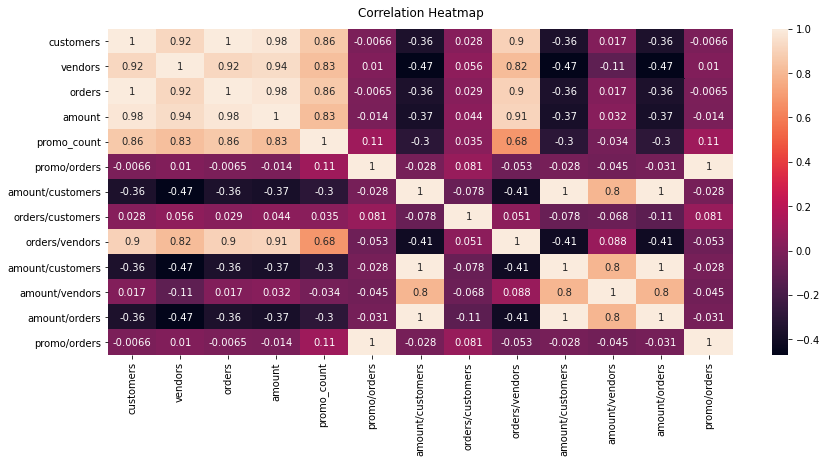

In [6]:
plt.figure(figsize=(14, 6))
corr = sns.heatmap(sales_df[['customers','vendors','orders','amount','promo_count',
        'promo/orders','amount/customers','orders/customers', 'orders/vendors', 'amount/customers', 
        'amount/vendors', 'amount/orders','promo/orders']].corr(),annot=True)
corr.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [7]:
sales_df[['other_devices','iPhone','Android','GCF','Macintosh','Tablet','Windows','X11']].sum()/sales_df['customers'].sum()

other_devices    0.620932
iPhone           0.298960
Android          0.055556
GCF              0.017731
Macintosh        0.001077
Tablet           0.000579
Windows          0.002265
X11              0.002899
dtype: float64

In [8]:
sales_df['promo_count'].sum()/sales_df['orders'].sum()

0.02073904872054359

In [9]:
sales_df['Blacklisted'].sum()/sales_df['customers'].sum()

8.998147440232894e-05

### Business Overview

In [10]:
sales_df_daily = sales_df.groupby(['trans_date','dayofweek','week']).agg({
                            'customers':'sum','orders':'sum','amount':'sum','vendors':'max','promo_count':'sum',
                            'phone':'sum','laptop':'sum','other_devices':'sum'}).reset_index()
sales_df_daily['promo%'] = sales_df_daily['promo_count']/sales_df_daily['orders']

In [11]:
sales_df_daily['orders/customers'] = sales_df_daily['orders']/sales_df_daily['customers']
sales_df_daily['orders/vendors'] = sales_df_daily['orders']/sales_df_daily['vendors']
sales_df_daily['amount/customers'] = sales_df_daily['amount']/sales_df_daily['customers']
sales_df_daily['amount/vendors'] = sales_df_daily['amount']/sales_df_daily['vendors']
sales_df_daily['amount/orders'] = sales_df_daily['amount']/sales_df_daily['orders']
sales_df_daily['promo/orders'] = sales_df_daily['promo_count']/sales_df_daily['orders']

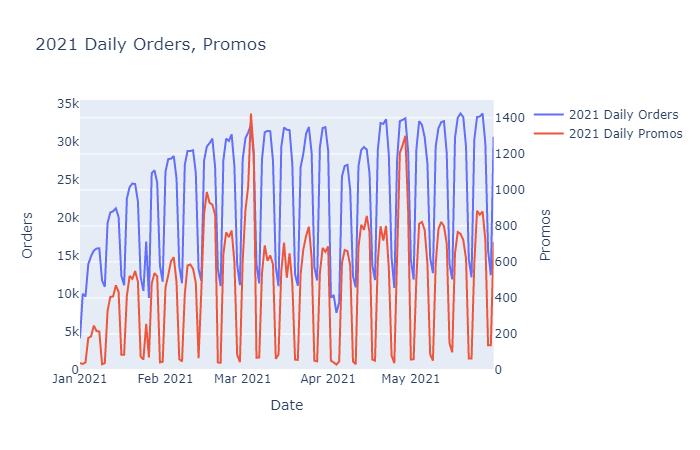

In [13]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=sales_df_daily['trans_date'], y=sales_df_daily['orders'], name="2021 Daily Orders")) 
fig.add_trace(go.Scatter(x=sales_df_daily['trans_date'], y=sales_df_daily['promo_count'], 
                         name="2021 Daily Promos"),secondary_y=True)    

fig.update_layout(title_text=f"2021 Daily Orders, Promos", width=1000, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Date", showgrid=False)
fig.update_yaxes(title_text="Orders", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="Promos", secondary_y=True, rangemode="tozero")

fig.show("png")

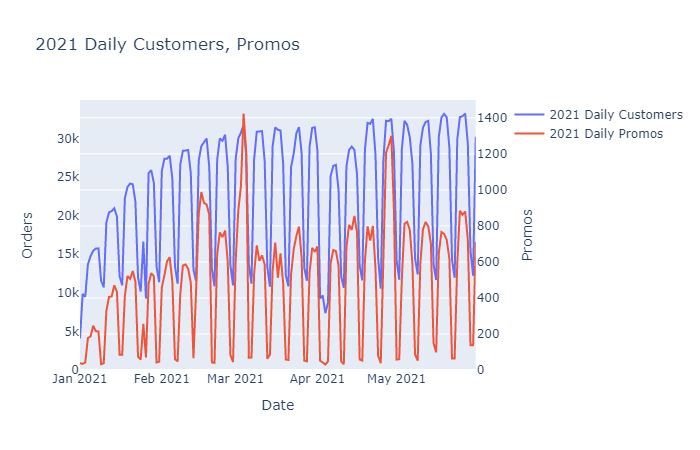

In [14]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=sales_df_daily['trans_date'], y=sales_df_daily['customers'], name="2021 Daily Customers")) 
fig.add_trace(go.Scatter(x=sales_df_daily['trans_date'], y=sales_df_daily['promo_count'], 
                         name="2021 Daily Promos"),secondary_y=True)    

fig.update_layout(title_text=f"2021 Daily Customers, Promos", width=1000, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Date", showgrid=False)
fig.update_yaxes(title_text="Orders", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="Promos", secondary_y=True, rangemode="tozero")

fig.show("png")

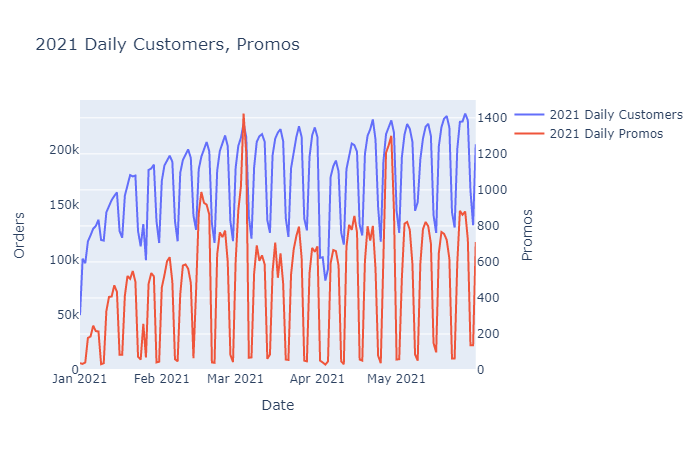

In [15]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=sales_df_daily['trans_date'], y=sales_df_daily['amount'], name="2021 Daily Customers")) 
fig.add_trace(go.Scatter(x=sales_df_daily['trans_date'], y=sales_df_daily['promo_count'], 
                         name="2021 Daily Promos"),secondary_y=True)    

fig.update_layout(title_text=f"2021 Daily Customers, Promos", width=1000, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Date", showgrid=False)
fig.update_yaxes(title_text="Orders", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="Promos", secondary_y=True, rangemode="tozero")

fig.show("png")

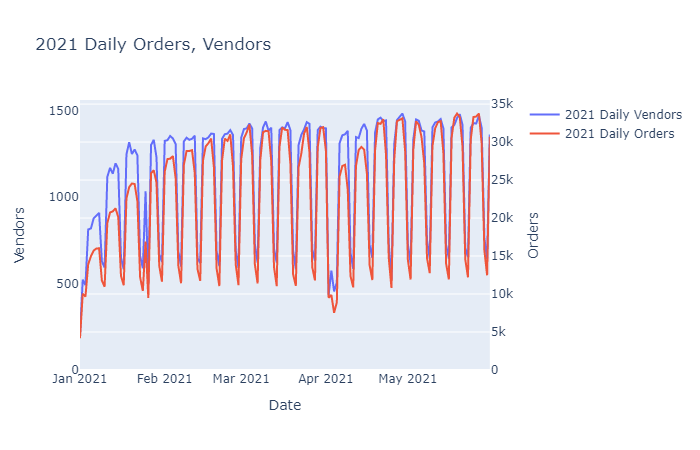

In [16]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=sales_df_daily['trans_date'], y=sales_df_daily['vendors'], name="2021 Daily Vendors")) 
fig.add_trace(go.Scatter(x=sales_df_daily['trans_date'], y=sales_df_daily['orders'], 
                         name="2021 Daily Orders"),secondary_y=True)    

fig.update_layout(title_text=f"2021 Daily Orders, Vendors", width=1000, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Date", showgrid=False)
fig.update_yaxes(title_text="Vendors", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="Orders", secondary_y=True, rangemode="tozero")

fig.show("png")

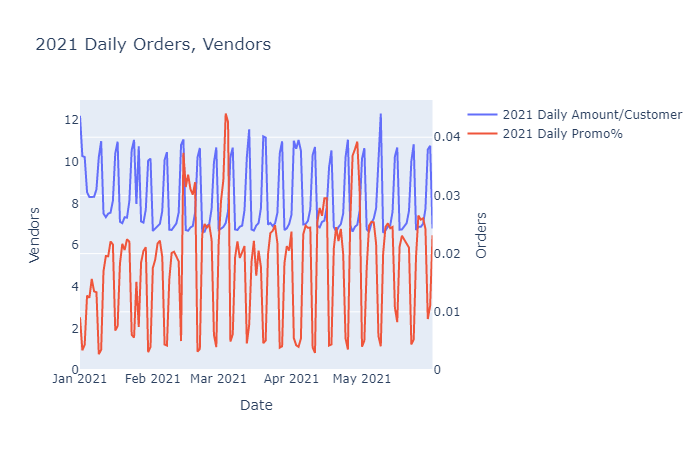

In [17]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=sales_df_daily['trans_date'], y=sales_df_daily['amount/customers'], name="2021 Daily Amount/Customer")) 
fig.add_trace(go.Scatter(x=sales_df_daily['trans_date'], y=sales_df_daily['promo/orders'], 
                         name="2021 Daily Promo%"),secondary_y=True)    

fig.update_layout(title_text=f"2021 Daily Orders, Vendors", width=1000, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Date", showgrid=False)
fig.update_yaxes(title_text="Vendors", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="Orders", secondary_y=True, rangemode="tozero")

fig.show("png")

In [18]:
sales_df_weekly = sales_df[~sales_df['week'].isin([53,22])].groupby(['week']).agg({
                            'customers':'sum','orders':'sum','amount':'sum','vendors':'max','promo_count':'sum',
                            'phone':'sum','laptop':'sum','other_devices':'sum'}).reset_index()
sales_df_weekly['promo%'] = sales_df_weekly['promo_count']/sales_df_weekly['orders']

sales_df_weekly['amount_growth_wow'] = sales_df_weekly['amount'].diff()/sales_df_weekly['amount']
sales_df_weekly['orders_growth_wow'] = sales_df_weekly['orders'].diff()/sales_df_weekly['orders']

In [19]:
sales_df_weekly

,week,customers,orders,amount,vendors,promo_count,phone,laptop,other_devices,promo%,amount_growth_wow,orders_growth_wow
0,1,97622.0,99354.0,870845.20,908.0,1110.0,36116.0,638.0,58454.0,0.011172,NaN,NaN
1,2,124008.0,125912.0,1013652.84,1194.0,2214.0,44248.0,832.0,76352.0,0.017584,0.140884,0.210925
2,3,138080.0,140502.0,1093740.30,1316.0,2612.0,48250.0,894.0,86512.0,0.018590,0.073223,0.103842
3,4,126328.0,128576.0,1034324.28,1330.0,1950.0,44454.0,768.0,78768.0,0.015166,-0.057444,-0.092754
4,5,157632.0,160176.0,1183949.12,1352.0,2812.0,53268.0,976.0,100766.0,0.017556,0.126378,0.197283
5,6,161870.0,164506.0,1225991.10,1354.0,3136.0,54424.0,906.0,103692.0,0.019063,0.034292,0.026321
6,7,165680.0,168372.0,1232217.56,1366.0,4644.0,56330.0,960.0,105630.0,0.027582,0.005053,0.022961
7,8,168250.0,171066.0,1254960.32,1386.0,3646.0,57634.0,942.0,106882.0,0.021313,0.018122,0.015748
8,9,172432.0,175458.0,1293137.38,1424.0,5280.0,59086.0,962.0,109528.0,0.030093,0.029523,0.025032
9,10,171112.0,174004.0,1286763.24,1436.0,3204.0,59346.0,998.0,107968.0,0.018413,-0.004954,-0.008356


In [20]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=sales_df_weekly['week'], y=sales_df_weekly['orders'], name="2021 Weekly Orders")) 
fig.add_trace(go.Scatter(x=sales_df_weekly['week'], y=sales_df_weekly['orders_growth_wow'], 
                         name="2021 WoW Orders Growth"), secondary_y=True)

fig.update_layout(title_text=f"2021 Weekly Orders", width=1000, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Week", showgrid=False)
fig.update_yaxes(title_text="Orders", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="%Growth WoW", secondary_y=True, rangemode="tozero", tickformat="%")

fig.show()

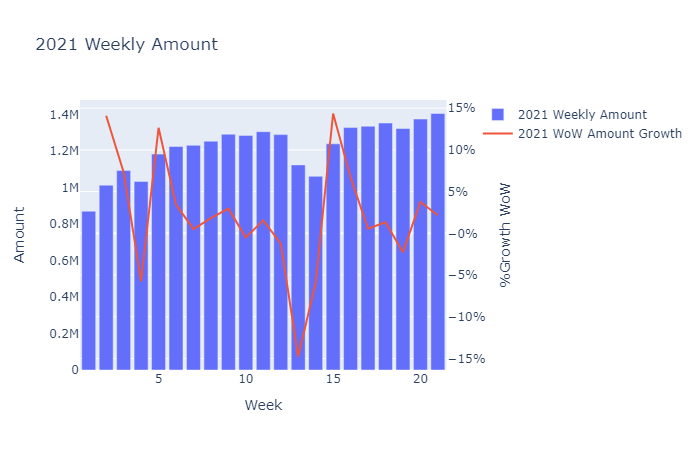

In [21]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=sales_df_weekly['week'], y=sales_df_weekly['amount'], name="2021 Weekly Amount")) 
fig.add_trace(go.Scatter(x=sales_df_weekly['week'], y=sales_df_weekly['amount_growth_wow'], 
                         name="2021 WoW Amount Growth"), secondary_y=True)

fig.update_layout(title_text=f"2021 Weekly Amount", width=1000, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Week", showgrid=False)
fig.update_yaxes(title_text="Amount", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="%Growth WoW", secondary_y=True, rangemode="tozero", tickformat="%")

fig.show("png")

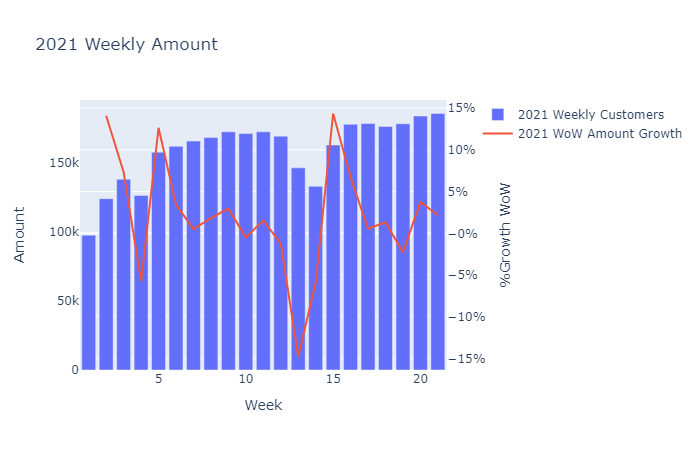

In [22]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=sales_df_weekly['week'], y=sales_df_weekly['customers'], name="2021 Weekly Customers")) 
fig.add_trace(go.Scatter(x=sales_df_weekly['week'], y=sales_df_weekly['amount_growth_wow'], 
                         name="2021 WoW Amount Growth"), secondary_y=True)

fig.update_layout(title_text=f"2021 Weekly Amount", width=1000, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Week", showgrid=False)
fig.update_yaxes(title_text="Amount", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="%Growth WoW", secondary_y=True, rangemode="tozero", tickformat="%")

fig.show("png")

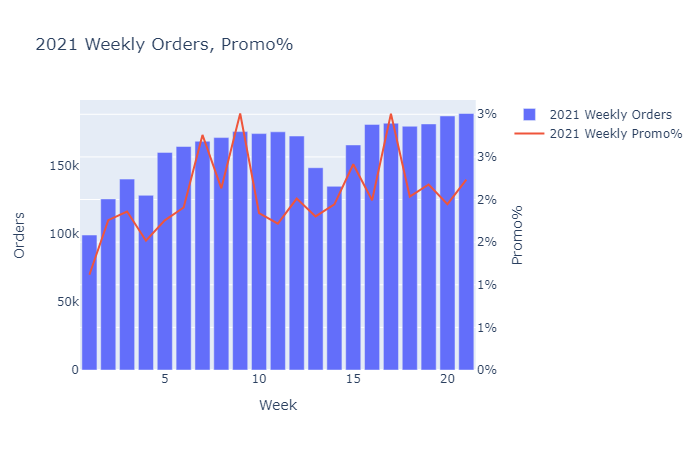

In [23]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=sales_df_weekly['week'], y=sales_df_weekly['orders'], name="2021 Weekly Orders")) 
fig.add_trace(go.Scatter(x=sales_df_weekly['week'], y=sales_df_weekly['promo%'], 
                         name="2021 Weekly Promo%"), secondary_y=True)

fig.update_layout(title_text=f"2021 Weekly Orders, Promo%", width=1000, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Week", showgrid=False)
fig.update_yaxes(title_text="Orders", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="Promo%", secondary_y=True, rangemode="tozero", tickformat="%")

fig.show("png")

### Customer Behavior

#### Day of the Week 

<AxesSubplot:xlabel='dayofweek', ylabel='Count'>

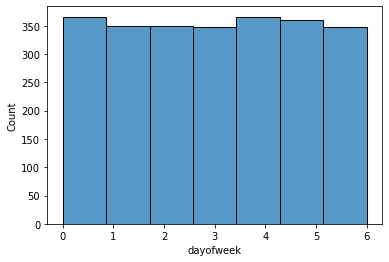

In [24]:
sns.histplot(sales_df['dayofweek'], bins=7)

In [25]:
summary_dow = sales_df_daily[~sales_df_daily['week'].isin([53,22])].groupby(['dayofweek'])[[
                            'customers','orders','amount','promo_count','vendors']].mean().reset_index()

summary_dow['%customers'] = summary_dow['customers']/summary_dow['customers'].sum()
summary_dow['%orders'] = summary_dow['orders']/summary_dow['orders'].sum()
summary_dow['%amount'] = summary_dow['amount']/summary_dow['amount'].sum()

summary_dow['amount/customers'] = summary_dow['amount']/summary_dow['customers']
summary_dow['orders/customers'] = summary_dow['orders']/summary_dow['customers']
summary_dow['promo/orders'] = summary_dow['promo_count']/summary_dow['orders']
summary_dow['orders/vendors'] = summary_dow['orders']/summary_dow['vendors']
summary_dow['amount/vendors'] = summary_dow['amount']/summary_dow['vendors']

In [26]:
dow_dict = {0:'Mon',1:'Tues',2:'Wed',3:"Thurs",4:'Fri',5:'Sat',6:'Sun'}
summary_dow['dayofweek'] = summary_dow['dayofweek'].map(dow_dict)

In [27]:
summary_dow

,dayofweek,customers,orders,amount,promo_count,vendors,%customers,%orders,%amount,amount/customers,orders/customers,promo/orders,orders/vendors,amount/vendors
0,Mon,25033.047619,25402.761905,174035.138095,509.428571,1251.809524,0.157062,0.156719,0.142520,6.952215,1.014769,0.020054,20.292833,139.026853
1,Tues,27692.571429,28119.428571,190916.314286,682.095238,1303.904762,0.173748,0.173479,0.156344,6.894135,1.015414,0.024257,21.565554,146.418910
2,Wed,28796.666667,29267.238095,201684.277143,700.190476,1352.095238,0.180675,0.180560,0.165162,7.003737,1.016341,0.023924,21.645841,149.164254
3,Thurs,28826.190476,29302.000000,205234.399048,744.666667,1365.142857,0.180860,0.180774,0.168070,7.119720,1.016506,0.025414,21.464420,150.339137
4,Fri,24814.000000,25263.333333,193250.429524,593.809524,1294.857143,0.155687,0.155858,0.158256,7.787960,1.018108,0.023505,19.510518,149.244595
5,Sat,13168.380952,13445.904762,135481.414286,68.952381,690.666667,0.082621,0.082952,0.110948,10.288388,1.021075,0.005128,19.468009,196.160349
6,Sun,11052.857143,11290.952381,120525.165714,77.142857,602.190476,0.069347,0.069658,0.098700,10.904435,1.021542,0.006832,18.749802,200.144590


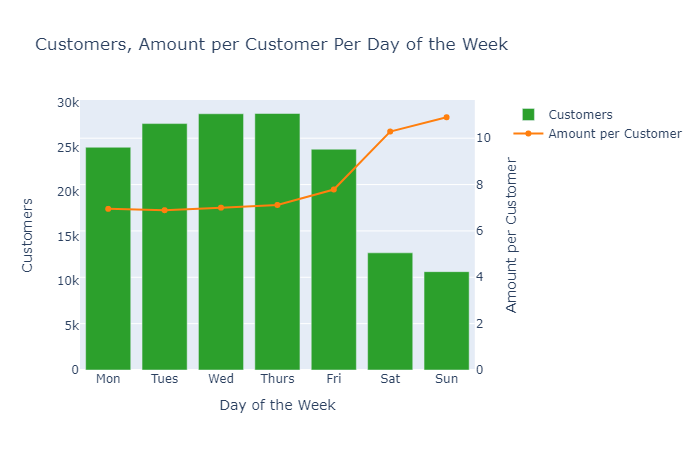

In [28]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=summary_dow['dayofweek'], y=summary_dow['customers'], name="Customers", marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=summary_dow['dayofweek'], y=summary_dow['amount/customers'], 
                         name="Amount per Customer", marker_color='#FF7F0E'), secondary_y=True)

fig.update_layout(title_text=f"Customers, Amount per Customer Per Day of the Week", width=700, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Day of the Week", showgrid=False)
fig.update_yaxes(title_text="Customers", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="Amount per Customer", secondary_y=True, rangemode="tozero")

fig.show("png")

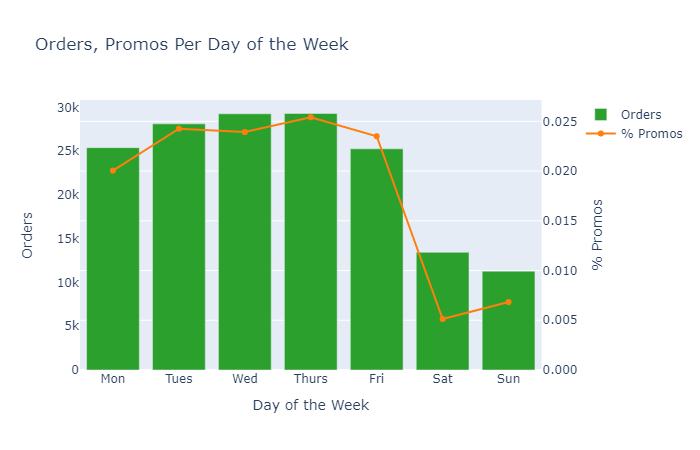

In [29]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=summary_dow['dayofweek'], y=summary_dow['orders'], name="Orders", marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=summary_dow['dayofweek'], y=summary_dow['promo/orders'], 
                         name="% Promos", marker_color='#FF7F0E'), secondary_y=True)

fig.update_layout(title_text=f"Orders, Promos Per Day of the Week", width=700, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Day of the Week", showgrid=False)
fig.update_yaxes(title_text="Orders", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="% Promos", secondary_y=True, rangemode="tozero", tickformat=".3f")

fig.show("png")

#### Device Usage

In [30]:
summary_devices_hour = sales_df[~sales_df['week'].isin([53,22])].groupby(['trans_hour'])[[
                            'Android', 'GCF', 'Macintosh', 'Tablet', 'Windows',
                           'X11', 'iPhone','other_devices','Blacklisted','Not Blacklisted','customers']].sum().reset_index()

summary_devices_hour['%Android'] = summary_devices_hour['Android']/summary_devices_hour['customers']
summary_devices_hour['%iphone'] = summary_devices_hour['iPhone']/summary_devices_hour['customers']
summary_devices_hour['%GCF'] = summary_devices_hour['GCF']/summary_devices_hour['customers']
summary_devices_hour['%Tablet'] = summary_devices_hour['Tablet']/summary_devices_hour['customers']
summary_devices_hour['%Macintosh'] = summary_devices_hour['Macintosh']/summary_devices_hour['customers']
summary_devices_hour['%Windows'] = summary_devices_hour['Windows']/summary_devices_hour['customers']
summary_devices_hour['%X11'] = summary_devices_hour['X11']/summary_devices_hour['customers']

## Dump Tablet, Mac, Windows, X11 to other devices
summary_devices_hour['%other_devices'] = 1 - summary_devices_hour[['%Android','%iphone','%GCF']].sum(axis=1)

In [31]:
summary_devices_hour

,trans_hour,Android,GCF,Macintosh,Tablet,Windows,X11,iPhone,other_devices,Blacklisted,Not Blacklisted,customers,%Android,%iphone,%GCF,%Tablet,%Macintosh,%Windows,%X11,%other_devices
0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,4.0,4.0,0.000000,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
1,1,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,6.0,6.0,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667
3,3,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,2.0,2.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,12.0,12.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
5,5,986.0,168.0,2.0,0.0,2.0,42.0,4822.0,8398.0,2.0,14418.0,14420.0,0.068377,0.334397,0.011650,0.000000,0.000139,0.000139,0.002913,0.585576
6,6,13254.0,3346.0,70.0,22.0,168.0,670.0,79282.0,125362.0,8.0,222166.0,222174.0,0.059656,0.356846,0.015060,0.000099,0.000315,0.000756,0.003016,0.568437
7,7,32046.0,9054.0,550.0,358.0,648.0,1640.0,191766.0,391330.0,24.0,627368.0,627392.0,0.051078,0.305656,0.014431,0.000571,0.000877,0.001033,0.002614,0.628835
8,8,46724.0,11872.0,904.0,346.0,1490.0,2194.0,255700.0,595056.0,54.0,914232.0,914286.0,0.051104,0.279672,0.012985,0.000378,0.000989,0.001630,0.002400,0.656239
9,9,33304.0,9116.0,576.0,360.0,1242.0,1358.0,168234.0,359952.0,24.0,574118.0,574142.0,0.058007,0.293018,0.015878,0.000627,0.001003,0.002163,0.002365,0.633098


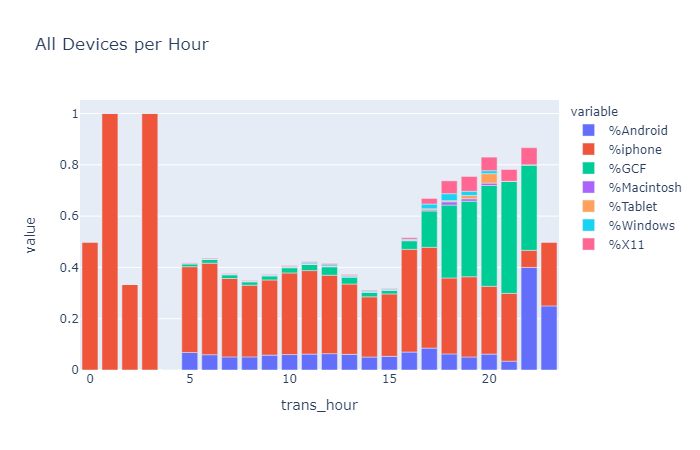

In [32]:
fig = px.bar(summary_devices_hour, x="trans_hour", y=["%Android", "%iphone", "%GCF",  '%Macintosh', '%Tablet', '%Windows',
                           '%X11'], title="All Devices per Hour")
fig.show("png")

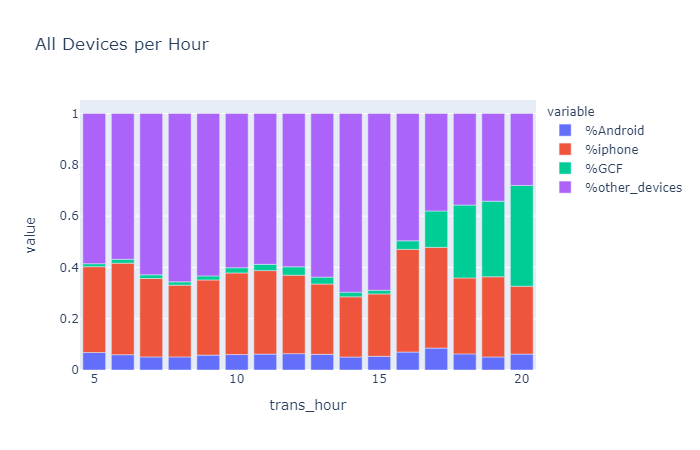

In [33]:
fig = px.bar(summary_devices_hour[summary_devices_hour['trans_hour'].between(5,20)], 
             x="trans_hour", y=["%Android", "%iphone", "%GCF", '%other_devices'], title="All Devices per Hour",
             width=800, height=400)

fig.show("png")

In [34]:
summary_devices_dow = sales_df[~sales_df['week'].isin([53,22])].groupby(['dayofweek'])[[
                            'Android', 'GCF', 'Macintosh', 'Tablet', 'Windows',
                           'X11', 'iPhone','other_devices','Blacklisted','Not Blacklisted','customers']].sum().reset_index()

summary_devices_dow['%iphone'] = summary_devices_dow['iPhone']/summary_devices_dow['customers']
summary_devices_dow['%Android'] = summary_devices_dow['Android']/summary_devices_dow['customers']
summary_devices_dow['%GCF'] = summary_devices_dow['GCF']/summary_devices_dow['customers']
summary_devices_dow['%Macintosh'] = summary_devices_dow['Macintosh']/summary_devices_dow['customers']
summary_devices_dow['%Tablet'] = summary_devices_dow['Tablet']/summary_devices_dow['customers']
summary_devices_dow['%Windows'] = summary_devices_dow['Windows']/summary_devices_dow['customers']
summary_devices_dow['%X11'] = summary_devices_dow['X11']/summary_devices_dow['customers']

summary_devices_dow['%other_devices'] = 1 - summary_devices_dow[['%Android','%iphone','%GCF']].sum(axis=1)

dow_dict = {0:'Mon',1:'Tues',2:'Wed',3:"Thurs",4:'Fri',5:'Sat',6:'Sun'}
summary_devices_dow['dayofweek'] = summary_devices_dow['dayofweek'].map(dow_dict)

In [35]:
summary_devices_dow

,dayofweek,Android,GCF,Macintosh,Tablet,Windows,X11,iPhone,other_devices,Blacklisted,Not Blacklisted,customers,%iphone,%Android,%GCF,%Macintosh,%Tablet,%Windows,%X11,%other_devices
0,Mon,28652.0,7856.0,572.0,258.0,1164.0,1382.0,152022.0,333788.0,60.0,525634.0,525694.0,0.289183,0.054503,0.014944,0.001088,0.000491,0.002214,0.002629,0.641369
1,Tues,31886.0,8744.0,592.0,284.0,1484.0,1442.0,166274.0,370838.0,46.0,581498.0,581544.0,0.285918,0.054830,0.015036,0.001018,0.000488,0.002552,0.002480,0.644216
2,Wed,34310.0,9212.0,632.0,314.0,1564.0,1572.0,175322.0,381804.0,42.0,604688.0,604730.0,0.289918,0.056736,0.015233,0.001045,0.000519,0.002586,0.002600,0.638113
3,Thurs,34982.0,9360.0,638.0,322.0,1490.0,1692.0,176304.0,380562.0,38.0,605312.0,605350.0,0.291243,0.057788,0.015462,0.001054,0.000532,0.002461,0.002795,0.635507
4,Fri,31188.0,9910.0,582.0,372.0,1332.0,1700.0,159780.0,316230.0,48.0,521046.0,521094.0,0.306624,0.059851,0.019018,0.001117,0.000714,0.002556,0.003262,0.614507
5,Sat,14052.0,7516.0,332.0,188.0,334.0,1014.0,93406.0,159694.0,28.0,276508.0,276536.0,0.337772,0.050814,0.027179,0.001201,0.000680,0.001208,0.003667,0.584235
6,Sun,11138.0,6706.0,252.0,192.0,240.0,868.0,77030.0,135684.0,38.0,232072.0,232110.0,0.331869,0.047986,0.028891,0.001086,0.000827,0.001034,0.003740,0.591254


In [36]:
fig = px.bar(summary_devices_dow, x="dayofweek", y=["%Android", "%iphone", "%GCF",  '%Macintosh', '%Tablet', '%Windows',
                           '%X11'], title="All Devices Day of Week")
fig.show()

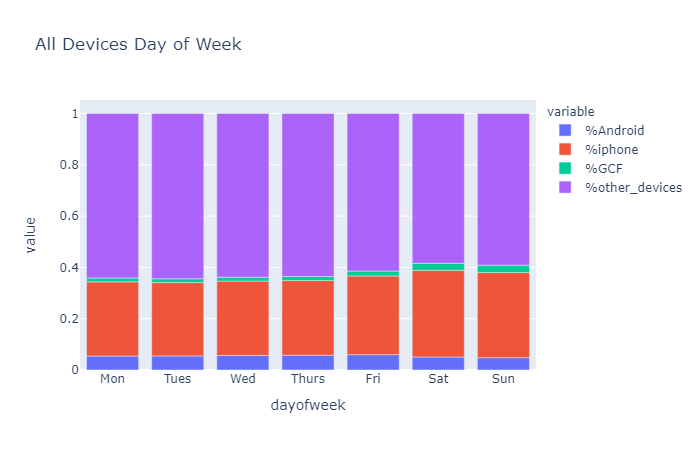

In [37]:
fig = px.bar(summary_devices_dow, x="dayofweek", y=["%Android", "%iphone", "%GCF", '%other_devices'], 
             title="All Devices Day of Week", width=800, height=400)
fig.show("png")

In [38]:
summary_devices_daily = sales_df[~sales_df['week'].isin([53,22])].groupby(['trans_date'])[[
                            'Android', 'GCF', 'Macintosh', 'Tablet', 'Windows',
                            'X11', 'iPhone','Blacklisted','Not Blacklisted','customers']].sum().reset_index()

summary_devices_daily['%Android'] = summary_devices_daily['Android']/summary_devices_daily['customers']
summary_devices_daily['%iphone'] = summary_devices_daily['iPhone']/summary_devices_daily['customers']
summary_devices_daily['%GCF'] = summary_devices_daily['GCF']/summary_devices_daily['customers']
summary_devices_daily['%Macintosh'] = summary_devices_daily['Macintosh']/summary_devices_daily['customers']
summary_devices_daily['%Windows'] = summary_devices_daily['Windows']/summary_devices_daily['customers']
summary_devices_daily['%X11'] = summary_devices_daily['X11']/summary_devices_daily['customers']
summary_devices_daily['%Tablet'] = summary_devices_daily['Tablet']/summary_devices_daily['customers']


# summary_devices_daily['%other_devices'] = summary_devices_daily['other_devices']/summary_devices_daily['customers']

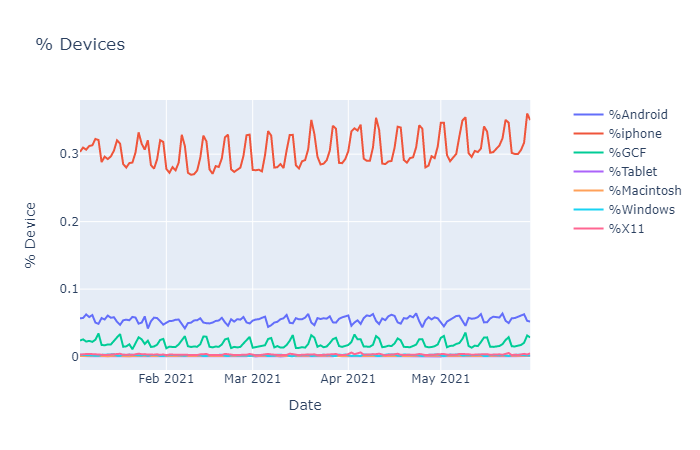

In [39]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

for device in ['%Android','%iphone','%GCF','%Tablet','%Macintosh','%Windows','%X11']:
    fig.add_trace(go.Scatter(x=summary_devices_daily['trans_date'], y=summary_devices_daily[f'{device}'], name=f"{device}"))

fig.update_layout(title_text="% Devices")
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="% Device", secondary_y=False)

fig.show("png")

#### Hour

In [40]:
summary_hour = sales_df[~sales_df['week'].isin([53,22])].groupby(['trans_hour'])[[
                            'customers','orders','amount','vendors','promo_count']].mean().reset_index()

summary_hour['%customers'] = summary_hour['customers']/summary_hour['customers'].sum()
summary_hour['%orders'] = summary_hour['orders']/summary_hour['orders'].sum()
summary_hour['%amount'] = summary_hour['amount']/summary_hour['amount'].sum()

summary_hour['amount/customers'] = summary_hour['amount']/summary_hour['customers']
summary_hour['orders/customers'] = summary_hour['orders']/summary_hour['customers']
summary_hour['promo/orders'] = summary_hour['promo_count']/summary_hour['orders']
summary_hour['orders/vendors'] = summary_hour['orders']/summary_hour['vendors']
summary_hour['amount/vendors'] = summary_hour['amount']/summary_hour['vendors']

<AxesSubplot:xlabel='trans_hour', ylabel='Count'>

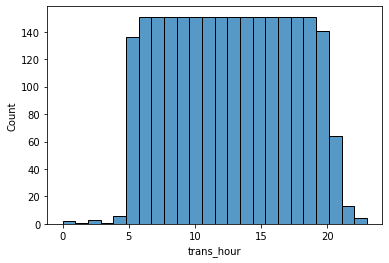

In [41]:
sns.histplot(sales_df['trans_hour'], bins=24)

In [42]:
summary_hour

,trans_hour,customers,orders,amount,vendors,promo_count,%customers,%orders,%amount,amount/customers,orders/customers,promo/orders,orders/vendors,amount/vendors
0,0,2.000000,2.000000,50.000000,2.000000,0.000000,0.000088,0.000086,0.000285,25.000000,1.000000,0.000000,1.000000,25.000000
1,1,2.000000,2.000000,200.000000,2.000000,0.000000,0.000088,0.000086,0.001142,100.000000,1.000000,0.000000,1.000000,100.000000
2,2,2.000000,2.000000,73.333333,2.000000,0.000000,0.000088,0.000086,0.000419,36.666667,1.000000,0.000000,1.000000,36.666667
3,3,2.000000,2.000000,100.000000,2.000000,0.000000,0.000088,0.000086,0.000571,50.000000,1.000000,0.000000,1.000000,50.000000
4,4,2.000000,2.000000,16.000000,2.000000,0.000000,0.000088,0.000086,0.000091,8.000000,1.000000,0.000000,1.000000,8.000000
5,5,106.814815,107.348148,766.044593,39.748148,0.518519,0.004686,0.004631,0.004373,7.171707,1.004993,0.004830,2.700708,19.272460
6,6,1511.387755,1529.823129,10770.933878,395.918367,11.278912,0.066307,0.065995,0.061492,7.126519,1.012198,0.007373,3.863986,27.204936
7,7,4267.972789,4332.789116,30210.755782,890.816327,66.761905,0.187242,0.186913,0.172475,7.078479,1.015187,0.015409,4.863841,33.913563
8,8,6219.632653,6317.891156,42654.244762,1110.122449,132.394558,0.272863,0.272548,0.243516,6.858001,1.015798,0.020955,5.691166,38.423009
9,9,3905.727891,3981.904762,29580.948163,990.108844,86.557823,0.171349,0.171776,0.168879,7.573735,1.019504,0.021738,4.021684,29.876461


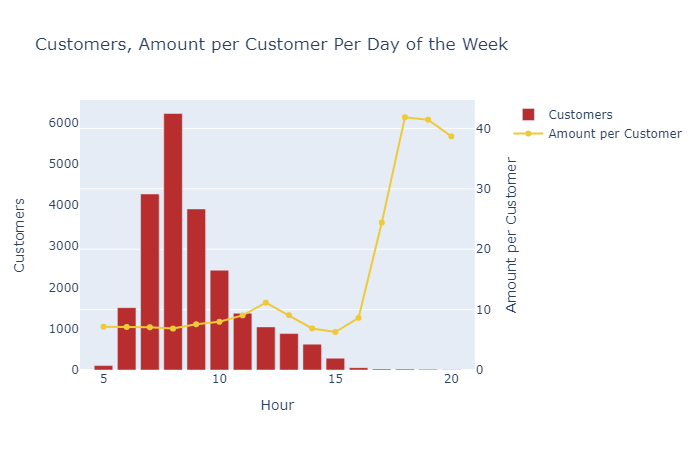

In [43]:
summary_hour2 = summary_hour[summary_hour['trans_hour'].between(5,20)]

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=summary_hour2['trans_hour'], y=summary_hour2['customers'], name="Customers", marker_color='#B82E2E'))
fig.add_trace(go.Scatter(x=summary_hour2['trans_hour'], y=summary_hour2['amount/customers'], 
                         name="Amount per Customer", marker_color='#EECA3B'), secondary_y=True)

fig.update_layout(title_text=f"Customers, Amount per Customer Per Day of the Week", width=700, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Hour", showgrid=False)
fig.update_yaxes(title_text="Customers", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="Amount per Customer", secondary_y=True, rangemode="tozero")

fig.show("png")

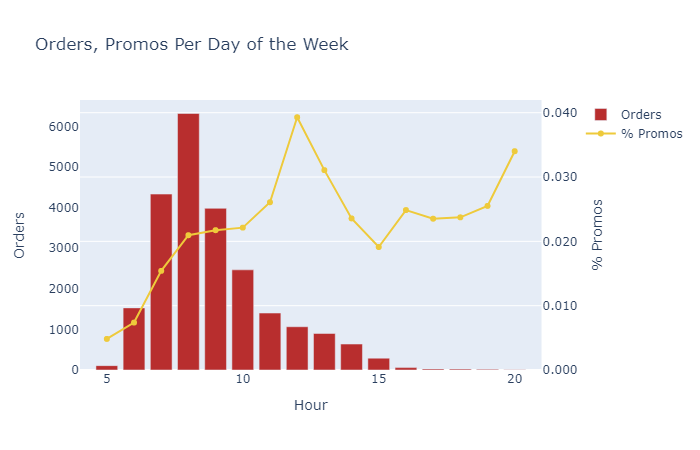

In [44]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=summary_hour2['trans_hour'], y=summary_hour2['orders'], name="Orders", marker_color='#B82E2E'))
fig.add_trace(go.Scatter(x=summary_hour2['trans_hour'], y=summary_hour2['promo/orders'], 
                         name="% Promos", marker_color='#EECA3B'), secondary_y=True)

fig.update_layout(title_text=f"Orders, Promos Per Day of the Week", width=700, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Hour", showgrid=False)
fig.update_yaxes(title_text="Orders", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="% Promos", secondary_y=True, rangemode="tozero", tickformat=".3f")

fig.show("png")

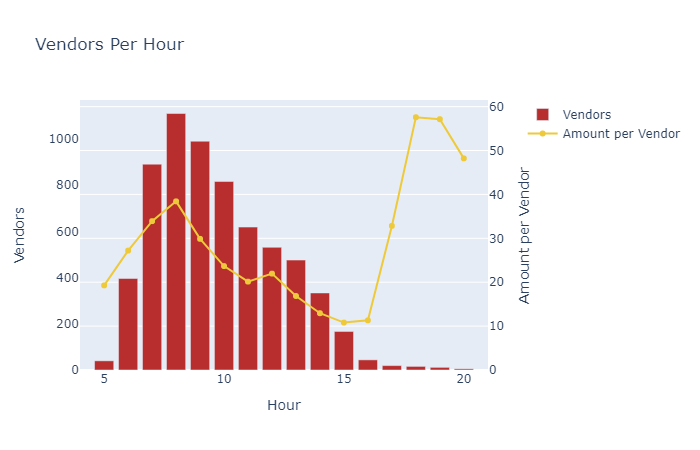

In [45]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=summary_hour2['trans_hour'], y=summary_hour2['vendors'], name="Vendors", marker_color='#B82E2E'))
fig.add_trace(go.Scatter(x=summary_hour2['trans_hour'], y=summary_hour2['amount/vendors'], 
                         name="Amount per Vendor", marker_color='#EECA3B'), secondary_y=True)

fig.update_layout(title_text=f"Vendors Per Hour", width=700, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Hour", showgrid=False)
fig.update_yaxes(title_text="Vendors", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="Amount per Vendor", secondary_y=True, rangemode="tozero")

fig.show("png")

### Impact of Promotions

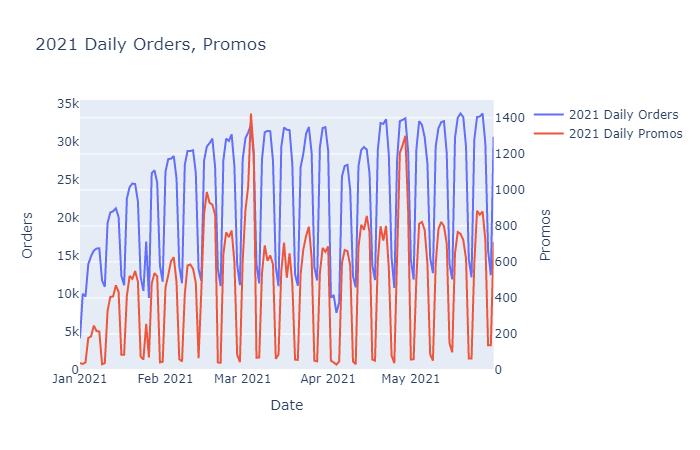

In [46]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=sales_df_daily['trans_date'], y=sales_df_daily['orders'], name="2021 Daily Orders")) 
fig.add_trace(go.Scatter(x=sales_df_daily['trans_date'], y=sales_df_daily['promo_count'], 
                         name="2021 Daily Promos"),secondary_y=True)    

fig.update_layout(title_text=f"2021 Daily Orders, Promos", width=1000, height=400, yaxis_showgrid=False)
fig.update_xaxes(title_text="Date", showgrid=False)
fig.update_yaxes(title_text="Orders", secondary_y=False, rangemode="tozero")
fig.update_yaxes(title_text="Promos", secondary_y=True, rangemode="tozero")

fig.show("png")

<AxesSubplot:xlabel='promo/orders', ylabel='Count'>

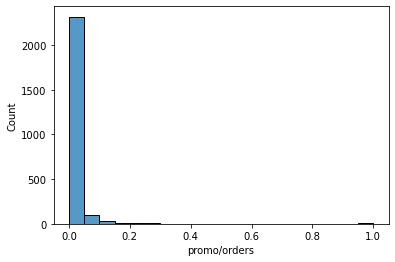

In [47]:
sns.histplot(sales_df['promo/orders'], binwidth=0.05)

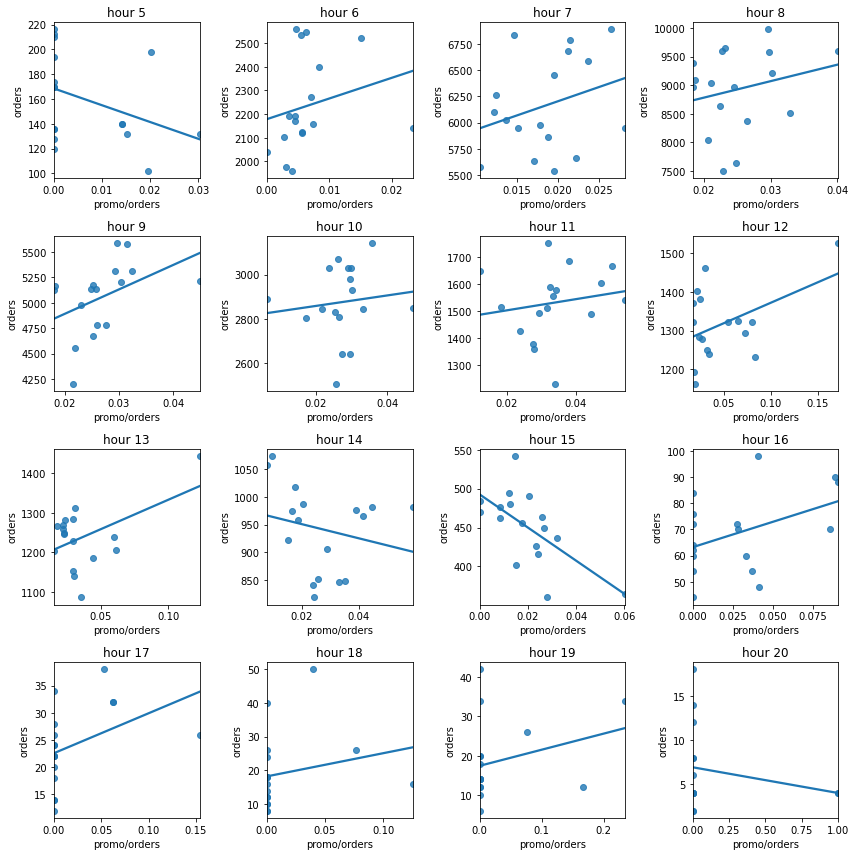

In [48]:
f, axes = plt.subplots(4, 4, figsize=(12,12))

for i in range(16): 
    hour = i + 5
    sns.regplot(data = sales_df[(sales_df['trans_hour']==hour)&(sales_df['dayofweek']==2)&(sales_df['week']>4)], 
                x='promo/orders', y='orders', ci=None, ax=axes[i//4, i%4]).set_title(f'hour {hour}')
    
plt.tight_layout()

In [50]:
def sales_plot_hour(dataframe, hour):
    df = dataframe[dataframe['trans_hour']==hour]
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Bar(x=df['trans_date'], y=df['orders'], name="2021 Weekly Orders"))
    fig.add_trace(go.Scatter(x=df['trans_date'], y=df['promo/orders'], name="2021 Weekly Promos"), secondary_y=True)    
#     fig.add_trace(go.Scatter(x=df['trans_date'], y=df['promo%'], name="2021 Weekly %Promo"), secondary_y=True)    

    fig.update_layout(title_text=f"2021 Weekly Orders, Promos - Hour {hour}", width=1000, height=400, yaxis_showgrid=False)
    fig.update_xaxes(title_text="Date")
    fig.update_yaxes(title_text="Orders", secondary_y=False)
    fig.update_yaxes(title_text="%Promo", secondary_y=False)

    fig.show("png")

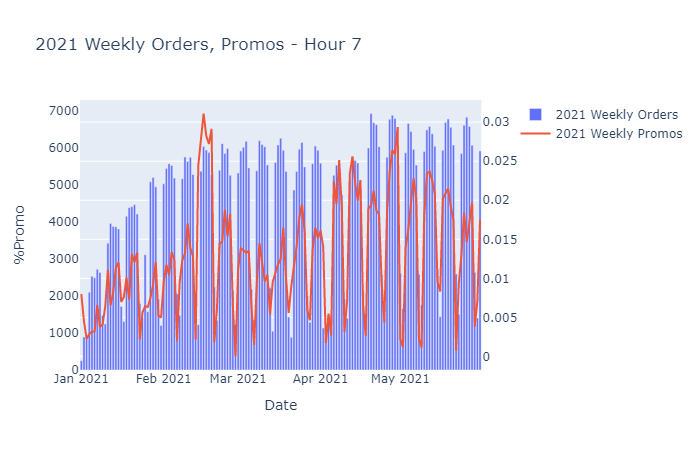

In [51]:
sales_plot_hour(dataframe=sales_df, hour=7)

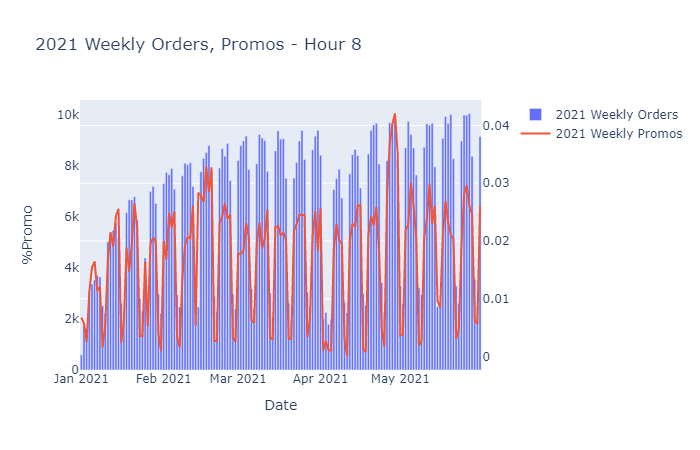

In [52]:
sales_plot_hour(dataframe=sales_df, hour=8)

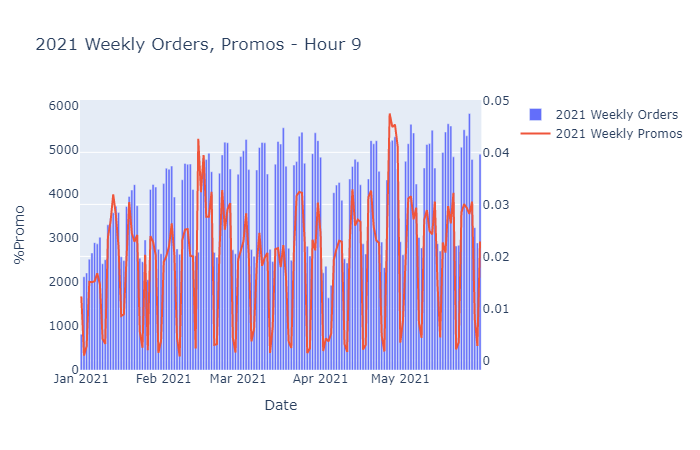

In [53]:
sales_plot_hour(dataframe=sales_df, hour=9)

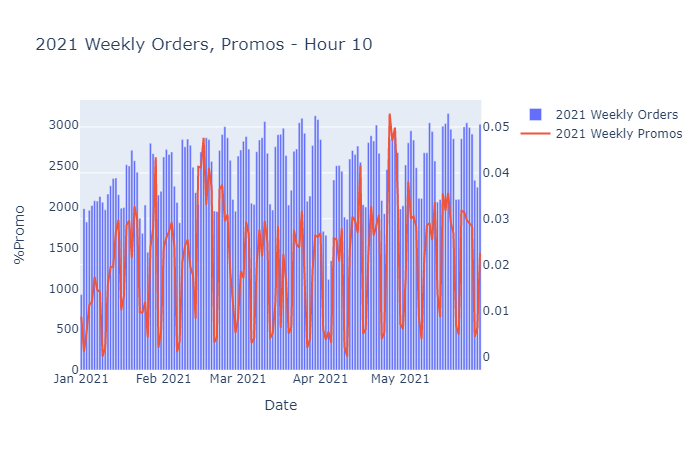

In [54]:
sales_plot_hour(dataframe=sales_df, hour=10)

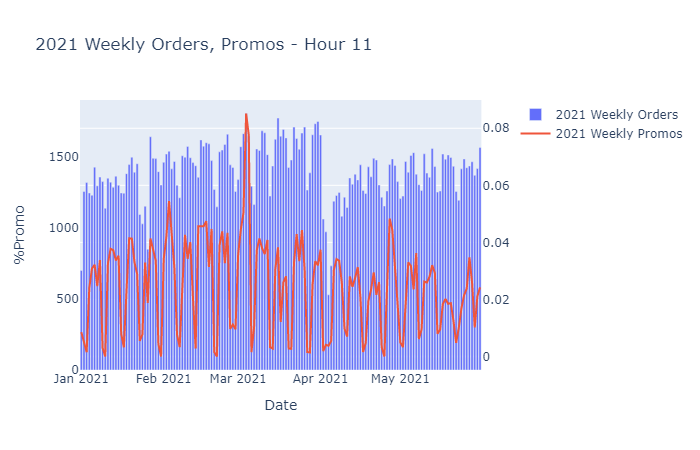

In [55]:
sales_plot_hour(dataframe=sales_df, hour=11)

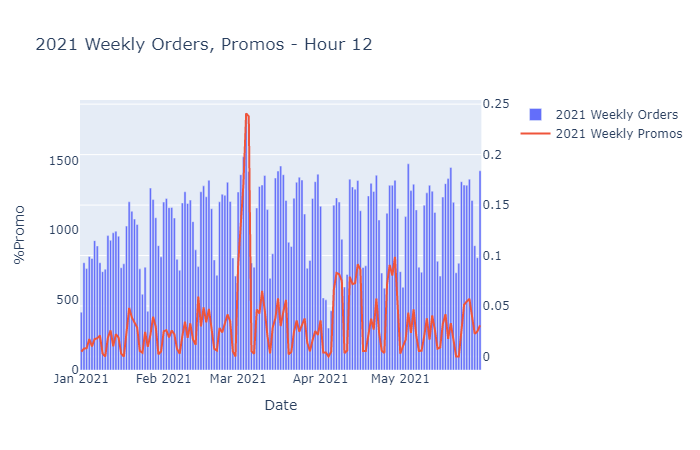

In [56]:
sales_plot_hour(dataframe=sales_df, hour=12)

In [57]:
def plot_day(dataframe, date_pw, date):
    df_pastweek = dataframe[(dataframe['trans_date']==date_pw)&(dataframe['trans_hour'].between(5,20))]
    df = dataframe[(dataframe['trans_date']==date)&(dataframe['trans_hour'].between(5,20))]
    
    df_pastweek['promo%'] = df_pastweek['promo_count']/df_pastweek['orders']
    df['promo%'] = df['promo_count']/df['orders']
    
    fig = make_subplots(specs=[[{"secondary_y": True}]])

    fig.add_trace(go.Bar(x=df_pastweek['trans_hour'], y=df_pastweek['orders'], name=f"{date_pw} Orders")) 
    fig.add_trace(go.Bar(x=df['trans_hour'], y=df['orders'], name=f"{date} Orders")) 
    fig.add_trace(go.Scatter(x=df_pastweek['trans_hour'], y=df_pastweek['promo%'], name=f"{date_pw} Promo%"), secondary_y=True)    
    fig.add_trace(go.Scatter(x=df['trans_hour'], y=df['promo%'], name=f"{date} Promo%"), secondary_y=True)  
    
    fig.update_layout(title_text=f"{date} vs {date_pw} Orders, Promo%", width=1000, height=400, yaxis_showgrid=False)
    fig.update_xaxes(title_text="Hour", showgrid=False)
    fig.update_yaxes(title_text="Orders", secondary_y=False, rangemode="tozero")
    fig.update_yaxes(title_text="Promo%", secondary_y=True, rangemode="tozero")

    fig.show("png")

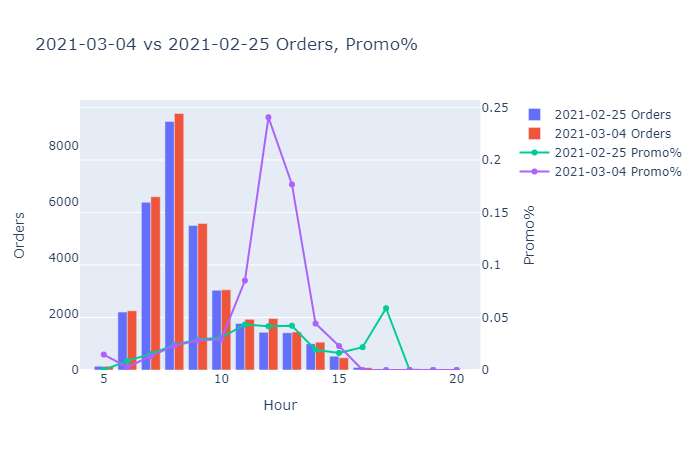

In [58]:
plot_day(dataframe=sales_df, date_pw='2021-02-25', date='2021-03-04')

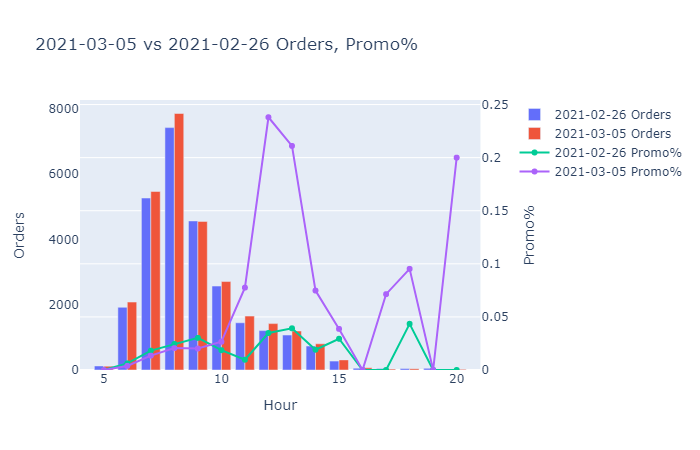

In [59]:
plot_day(dataframe=sales_df, date_pw='2021-02-26', date='2021-03-05')

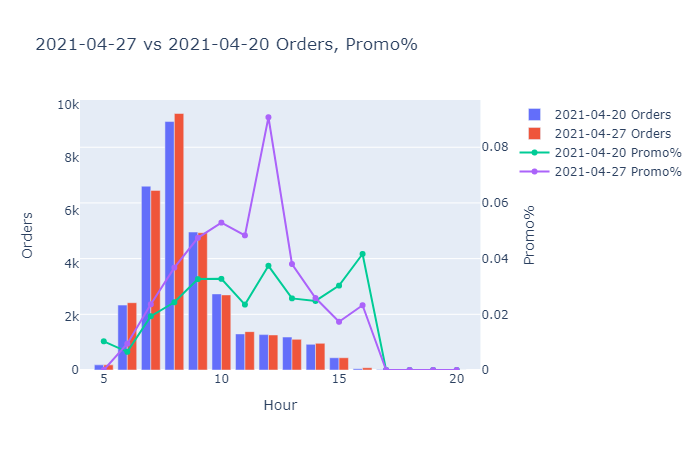

In [60]:
plot_day(dataframe=sales_df, date_pw='2021-04-20',date='2021-04-27')

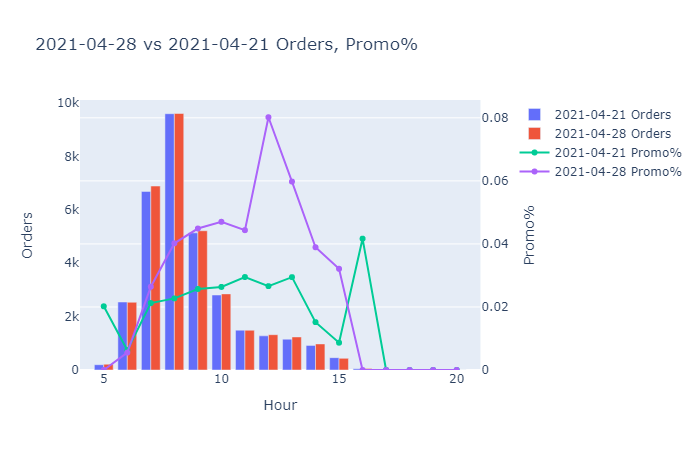

In [61]:
plot_day(dataframe=sales_df, date_pw='2021-04-21', date='2021-04-28')